In [ ]:
%%capture
!pip install transformers bertopic accelerate bitsandbytes xformers adjustText datamapplot umap-learn

In [ ]:
from google.colab import drive

import pandas as pd

from huggingface_hub import notebook_login

from torch import cuda
from torch import bfloat16

import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from sentence_transformers import SentenceTransformer

from umap import UMAP
from hdbscan import HDBSCAN

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import datamapplot
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora

import nltk
from nltk.corpus import stopwords



In [ ]:
# Request access to drive
drive.mount('/content/drive')

In [ ]:
# Load the dataset
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Comparing Transformer models/preprocessed_historical_data.csv')
# ai_jobs_mixedbread_subset_05
# preprocessed_historical_data
dataset

In [ ]:
# Fill missing values in the "description" column with an empty string
dataset["cleaned_description"] = dataset["cleaned_description"].fillna("")

# Ensure all values are strings
dataset["cleaned_description"] = dataset["cleaned_description"].astype(str)

# Combine titles and descriptions into a single column
dataset["combined"] = dataset["cleaned_title"] + " " + dataset["cleaned_description"]

# Convert combined column to a list
titles = dataset["cleaned_title"]
description = dataset["cleaned_description"]
combined = dataset["combined"].astype(str)

# Extract timestamps
timestamps = dataset['original_listed_time'].to_list()

# Preview an entry
print(f"Example combined entry: {dataset['combined'].iloc[0]}")

Example combined entry: full stack engineer location remote company overview skillfit subsidiary ideando platform revolutionizes talent acquisition process connecting job seeker recruiter seamless efficient manner mission leverage technology enhance job search experience candidate employer ultimately driving better outcome reducing frustration hiring process position overview seeking talented experienced freelance software engineer collaborate dynamic team project basis ideal candidate passion building innovative software solution strong foundation technology desire contribute startup environment key collaborate product team understand requirement design solution implement new feature functionality skillfit develop robust scalable maintainable code across full stack including ui component service database integration api participate code review architectural discussion technical planning session ensure code quality performance adherence best work closely team including product manageme

In [ ]:
def compute_coherence_score(topic_model, combined, topics, coherence_type='c_v'):
    """
    Computes the coherence score for a BERTopic model.

    Parameters:
    - topic_model: BERTopic
        The trained BERTopic model.
    - combined: List[str]
        The list of input documents used in training the model.
    - topics: List[int]
        The topic assignments for the documents.
    - coherence_type: str
        The type of coherence metric to use. Default is 'c_v'.

    Returns:
    - float
        The computed coherence score.
    """
    # Group documents by topic
    documents = pd.DataFrame({"Document": combined, "ID": range(len(combined)), "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Create tokens, dictionary, and corpus
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    # Extract topic words
    topic_words = [
        [word for word, _ in topic_model.get_topic(topic)]
        for topic in range(len(set(topics)) - 1)
    ]

    # Compute coherence

    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence=coherence_type
    )
    coherence = coherence_model.get_coherence()

    print(f"Coherence Score ({coherence_type}): {coherence}")
    return coherence

In [ ]:
# Sample competencies (predefined competency list)
competencies = [
    "Knowledge representation and reasoning",
    "Automated planning and scheduling",
    "Machine learning",
    "Natural language processing",
    "Machine perception",
    "Computer vision",
    "Speech recognition",
    "Robotics",
    "Affective computing",
    "Deep learning",
    "Information retrieval",
    "Causality",
    "Data mining",
    "Commonsense knowledge",
    "Intelligent agents",
]

In [ ]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer('mixedbread-ai/mxbai-embed-large-v1')
job_embeddings = embedding_model.encode(combined, show_progress_bar=True)

competency_embeddings = embedding_model.encode(competencies, show_progress_bar=True)


Batches:   0%|          | 0/144 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Compute cosine similarity matrix (jobs × competencies)
similarity_matrix = cosine_similarity(job_embeddings, competency_embeddings)

# Compute the average similarity per job (row-wise mean)
avg_similarity_per_job = np.mean(similarity_matrix, axis=1)

# Compute the overall average similarity (mean across all jobs)
overall_avg_similarity = np.mean(avg_similarity_per_job)

print(f"Average Cosine Similarity per Job: {avg_similarity_per_job}")
print(f"Overall Average Cosine Similarity: {overall_avg_similarity:.4f}")

Average Cosine Similarity per Job: [0.44553426 0.4653212  0.4665902  ... 0.44992292 0.45904732 0.49099883]
Overall Average Cosine Similarity: 0.4647


In [ ]:
nltk.download('stopwords')

job_stopwords = ["experience", "team", "work", "job", "position", "company", "customer", "sale"]

custom_stopwords = stopwords.words("english") + job_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# FULL DATASET

# Use the updated stopwords in the vectorizer
vectorizer_model = CountVectorizer(stop_words=custom_stopwords)

# Reduce dimensionality using UMAP
umap_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.5, metric='cosine', random_state=42)
reduced_job_embeddings = umap_model.fit_transform(job_embeddings)

# Transform competency embeddings using the same UMAP model
reduced_competency_embeddings = umap_model.transform(competency_embeddings)

# Train BERTopic model
vectorizer_model = vectorizer_model
hdbscan_model = HDBSCAN(min_cluster_size=50, metric="euclidean", cluster_selection_method="eom", prediction_data=True)

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    min_topic_size=50,
    n_gram_range=(1, 3),
    verbose=True,
    calculate_probabilities=False
)

topics, probs = topic_model.fit_transform(combined, job_embeddings)

2025-01-30 18:02:59,799 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-30 18:03:09,388 - BERTopic - Dimensionality - Completed ✓
2025-01-30 18:03:09,390 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-30 18:03:09,555 - BERTopic - Cluster - Completed ✓
2025-01-30 18:03:09,559 - BERTopic - Representation - Extracting topics from clusters using representation models.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py", line 1376, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py", line None, in _count_vocab
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-ca737d695312>", line 27, in <cell line: 0>
    topics, probs = topic_model.fit_transform(

In [ ]:
# AI DATASET

# Use the updated stopwords in the vectorizer
vectorizer_model = CountVectorizer(stop_words=custom_stopwords)

# Reduce dimensionality using UMAP
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.1, metric='cosine', random_state=42)
reduced_job_embeddings = umap_model.fit_transform(job_embeddings)

# Transform competency embeddings using the same UMAP model
reduced_competency_embeddings = umap_model.transform(competency_embeddings)

# Train BERTopic model
# vectorizer_model = CountVectorizer(stop_words="english")
vectorizer_model = vectorizer_model
hdbscan_model = HDBSCAN(min_cluster_size=10, metric="euclidean", cluster_selection_method="eom", prediction_data=True)

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    min_topic_size=20,
    n_gram_range=(1, 3),
    verbose=True,
    calculate_probabilities=True
)

topics, probs = topic_model.fit_transform(combined, job_embeddings)


2025-01-30 18:09:05,483 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-30 18:09:10,956 - BERTopic - Dimensionality - Completed ✓
2025-01-30 18:09:10,958 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-30 18:09:13,958 - BERTopic - Cluster - Completed ✓
2025-01-30 18:09:13,963 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-30 18:09:15,490 - BERTopic - Representation - Completed ✓


In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1236,-1_data_business_learning_technology,"[data, business, learning, technology, skill, ...",[senior manager product manager cloud security...
1,0,113,0_data_pipeline_snowflake_databricks,"[data, pipeline, snowflake, databricks, spark,...",[data engineer remote data engineer remote com...
2,1,75,1_biology_bioinformatics_molecular_research,"[biology, bioinformatics, molecular, research,...",[life science research professional 1 departme...
3,2,64,2_software_engineer_senior_development,"[software, engineer, senior, development, engi...",[senior software engineer power apps powerapps...
4,3,57,3_software_development_design_code,"[software, development, design, code, applicat...",[5g system architect sr principal software dev...
...,...,...,...,...,...
123,122,11,122_learning_cengage_tutoring_fortive,"[learning, cengage, tutoring, fortive, scoring...",[strategic partnership manager remote believe ...
124,123,11,123_recording_audio_prompt_series,"[recording, audio, prompt, series, project, pa...",[work home audio collector welcome thank inter...
125,124,10,124_intern_actian_internship_marketing,"[intern, actian, internship, marketing, deib, ...",[engineering intern zen hardware company visio...
126,125,10,125_cloudbeds_guest_reservation_php,"[cloudbeds, guest, reservation, php, hotel, 20...",[staff back end engineer re guest cloudbeds pr...


In [ ]:
plot = topic_model.visualize_documents(titles, reduced_embeddings=reduced_job_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)
plot

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # Reduce outliers
# reduced_outliers = topic_model.reduce_outliers(documents=combined, topics=topics, strategy="probabilities", probabilities=probs)
# topic_model.update_topics(docs=combined, topics=reduced_outliers)

# Reduce topipcs
topic_model.reduce_topics(combined, nr_topics=50)

2025-01-30 18:09:39,219 - BERTopic - Topic reduction - Reducing number of topics
2025-01-30 18:09:40,685 - BERTopic - Topic reduction - Reduced number of topics from 128 to 50


In [ ]:
# Generate BERTopic visualization with job postings
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_job_embeddings,
    hide_annotations=True,
    hide_document_hover=False,
    custom_labels=True
)

# Extract existing traces from BERTopic plot
existing_traces = list(fig.data)  # Extract traces

# Convert **ALL** BERTopic traces to WebGL (Scattergl) and assign to "Topics" legend
webgl_traces = []
for trace in existing_traces:
    webgl_traces.append(go.Scattergl(  # Convert all job posting traces to WebGL
        x=trace.x,
        y=trace.y,
        mode=trace.mode,
        marker=trace.marker,
        name=trace.name,
        hovertext=[trace.name] * len(trace.x),
        hoverinfo="text",
        legendgroup="Topics",  # Assign all job postings to "Topics" legend group
        showlegend=True
    ))

# Define distinct colors for competencies
competency_colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'gray',
    'cyan', 'lime', 'gold', 'navy', 'black', 'teal', 'magenta', 'indigo'
]

# **Ensure competencies are plotted LAST using WebGL (Scattergl)**
competency_traces = [
    go.Scattergl(  # Use Scattergl instead of Scatter
        x=[x],
        y=[y],
        mode='markers',
        marker=dict(
            symbol="x",
            size=14,  # Bigger for visibility
            color=competency_colors[i],  # Unique color per competency
            line=dict(width=2, color='black'),  # Black border
            opacity=1  # Ensure full visibility
        ),
        name=competencies[i] if i < len(competencies) else f"Competency {i}",
        hovertext=competencies[i] if i < len(competencies) else f"Competency {i}",  # Shows competency name on hover
        hoverinfo="text",
        legendgroup="Competencies",  # Assign to separate "Competencies" legend group
        showlegend=True
    )
    for i, (x, y) in enumerate(reduced_competency_embeddings)
]

# **Rebuild figure with WebGL job postings first, WebGL competencies last**
fig = go.Figure(data=webgl_traces + competency_traces)

# **Update layout with TWO separate legends**
fig.update_layout(
    title="BERTopic Visualization with Competencies",
    xaxis_title="UMAP Dimension 1",
    yaxis_title="UMAP Dimension 2",
    showlegend=True,

    # **Position the Topics legend on the LEFT**
    legend=dict(
        yanchor="top", y=0.99, xanchor="left", x=1.02,  # Adjust placement
    ),

    # **Create a second legend manually for Competencies**
    legend2=dict(
        yanchor="top", y=0.99, xanchor="left", x=1.4,  # Push further right
    ),
)

# **Manually add invisible traces to force separate legends**
fig.add_trace(go.Scatter(
    x=[None], y=[None], mode="markers",
    marker=dict(color="white"),
    name="Topics",
    legendgroup="Topics",
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=[None], y=[None], mode="markers",
    marker=dict(color="white"),
    name="Competencies",
    legendgroup="Competencies",
    showlegend=True,
    legendrank=2  # Move second legend separately
))

# Show updated Plotly visualization
fig.show()

In [ ]:
import plotly.io as pio

save_path = "/content/drive/My Drive/Colab Notebooks/Comparing Transformer models/mixedbread_ai_v2.html"
pio.write_html(fig, save_path)


In [ ]:
# # Reduce outliers
# reduced_outliers = topic_model.reduce_outliers(documents=combined, topics=topics, strategy="probabilities", probabilities=probs)
# topic_model.update_topics(docs=combined, topics=reduced_outliers)

# Reduce topipcs
topic_model.reduce_topics(combined, nr_topics=100)

2025-01-30 17:57:25,019 - BERTopic - Topic reduction - Reducing number of topics
2025-01-30 17:57:57,337 - BERTopic - Topic reduction - Reduced number of topics from 196 to 100


In [ ]:
# Generate BERTopic visualization with job postings
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_job_embeddings,
    hide_annotations=True,
    hide_document_hover=False,
    custom_labels=True
)

# Extract existing traces from BERTopic plot
existing_traces = list(fig.data)  # Extract traces

# Convert **ALL** BERTopic traces to WebGL (Scattergl) and assign to "Topics" legend
webgl_traces = []
for trace in existing_traces:
    webgl_traces.append(go.Scattergl(  # Convert all job posting traces to WebGL
        x=trace.x,
        y=trace.y,
        mode=trace.mode,
        marker=trace.marker,
        name=trace.name,
        hovertext=[trace.name] * len(trace.x),
        hoverinfo="text",
        legendgroup="Topics",  # Assign all job postings to "Topics" legend group
        showlegend=True
    ))

# Define distinct colors for competencies
competency_colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'gray',
    'cyan', 'lime', 'gold', 'navy', 'black', 'teal', 'magenta', 'indigo'
]

# **Ensure competencies are plotted LAST using WebGL (Scattergl)**
competency_traces = [
    go.Scattergl(  # Use Scattergl instead of Scatter
        x=[x],
        y=[y],
        mode='markers',
        marker=dict(
            symbol="x",
            size=14,  # Bigger for visibility
            color=competency_colors[i],  # Unique color per competency
            line=dict(width=2, color='black'),  # Black border
            opacity=1  # Ensure full visibility
        ),
        name=competencies[i] if i < len(competencies) else f"Competency {i}",
        hovertext=competencies[i] if i < len(competencies) else f"Competency {i}",  # Shows competency name on hover
        hoverinfo="text",
        legendgroup="Competencies",  # Assign to separate "Competencies" legend group
        showlegend=True
    )
    for i, (x, y) in enumerate(reduced_competency_embeddings)
]

# **Rebuild figure with WebGL job postings first, WebGL competencies last**
fig = go.Figure(data=webgl_traces + competency_traces)

# **Update layout with TWO separate legends**
fig.update_layout(
    title="BERTopic Visualization with Competencies",
    xaxis_title="UMAP Dimension 1",
    yaxis_title="UMAP Dimension 2",
    showlegend=True,

    # **Position the Topics legend on the LEFT**
    legend=dict(
        yanchor="top", y=0.99, xanchor="left", x=1.02,  # Adjust placement
    ),

    # **Create a second legend manually for Competencies**
    legend2=dict(
        yanchor="top", y=0.99, xanchor="left", x=1.4,  # Push further right
    ),
)

# **Manually add invisible traces to force separate legends**
fig.add_trace(go.Scatter(
    x=[None], y=[None], mode="markers",
    marker=dict(color="white"),
    name="Topics",
    legendgroup="Topics",
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=[None], y=[None], mode="markers",
    marker=dict(color="white"),
    name="Competencies",
    legendgroup="Competencies",
    showlegend=True,
    legendrank=2  # Move second legend separately
))

# Show updated Plotly visualization
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import plotly.io as pio

save_path = "/content/drive/My Drive/Colab Notebooks/Comparing Transformer models/all_mixedbread_v2.html"
pio.write_html(fig, save_path)



In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
score = compute_coherence_score(topic_model, combined, topics, coherence_type='c_v')


Coherence Score (c_v): 0.5719564026684


In [ ]:
score2 = compute_coherence_score(topic_model, combined, topics, coherence_type='c_v')


Coherence Score (c_v): 0.5187587900354979


In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,179,0_data_data engineer_engineer_experience,"[data, data engineer, engineer, experience, pi...",[data engineer remote data engineer remote com...
1,1,179,1_java_stack_full stack_experience,"[java, stack, full stack, experience, spring, ...",[senior developer job summary java developer r...
2,2,174,2_sale_partner_business_team,"[sale, partner, business, team, customer, data...",[manager digital sale company description serv...
3,3,110,3_test_testing_automation_qa,"[test, testing, automation, qa, quality, test ...",[senior quality assurance automation engineer ...
4,4,120,4_architecture_architect_solution_design,"[architecture, architect, solution, design, te...",[cloud architect looking cloud architect work ...
...,...,...,...,...,...
148,148,26,148_circana_palo alto_palo_alto,"[circana, palo alto, palo, alto, sale, palo al...",[named account manager mission palo alto every...
149,149,11,149_pearson_individual_individual required_opp...,"[pearson, individual, individual required, opp...",[senior engineer remote inclusive employer mem...
150,150,43,150_meta_video_reality_product,"[meta, video, reality, product, people connect...",[product marketing manager mixed reality devic...
151,151,11,151_ai community_online_task_community,"[ai community, online, task, community, map, o...",[online data analyst hiring freelance english ...


In [ ]:
# topics_to_merge = [[3, 6],
#                    [2, 10]]
# topic_model.merge_topics(combined, topics_to_merge)


100%|██████████| 55/55 [02:45<00:00,  3.02s/it]


In [ ]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=5, n_components=2, min_dist=0.1, metric='cosine', random_state=42).fit_transform(embeddings)


In [ ]:
topic_model.visualize_topics()

In [ ]:
plot = topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)
plot

In [ ]:
fig1 = topic_model.visualize_topics()
fig2 = topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

# Save the figure as an HTML file
fig1.write_html("/content/drive/My Drive/Colab Notebooks/Intertopic_dist_map2.html")
fig2.write_html("/content/drive/My Drive/Colab Notebooks/Documents_map2.html")


# Llama2 Model

Huggingface token:



In [ ]:
notebook_login()

In [ ]:
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


In [ ]:
# Set quantization configuration for loading large models with less GPU memory
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,             # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4",     # Use normalized float 4-bit precision
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Compute type for better performance
)

In [ ]:
# Model name for topic label generating
model_id = "meta-llama/Llama-2-7b-chat-hf"

In [ ]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id, use_auth_token=True)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=

In [ ]:
# Our text generator
generator = pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

Device set to use cuda:0


In [ ]:
prompt = "Could you explain to me how 4-bit quantization works as if I am 5?"
res = generator(prompt)
print(res[0]["generated_text"])

Could you explain to me how 4-bit quantization works as if I am 5?
 nobody likes a know-it-all, but I'm here to help! 😊

Quantization is like a magic trick where we make things smaller. Imagine you have a big box of toys, and inside that box, there are lots of different colors and shapes. But sometimes, it's hard to remember all the different colors and shapes, so we take a picture of the box and then we only remember the picture. That's kind of like what quantization does!

So, when we quantize something, like an image or sound, we take all the different colors and shapes (or sounds) and we group them together into just a few groups. We can only remember the groups, not all the individual colors and shapes (or sounds). It's like taking a picture of the box instead of trying to remember every single toy inside.

For example, let's say we have an image with lots of different colors, like red, blue, green, and yellow. We could group those colors into just two groups: "red" and "not red".

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful, and honest assistant for labeling topics. Your primary task is to identify AI-related competences and skills from the topics and generate concise labels based exclusively on the keywords provided.
<</SYS>>
"""

# Example prompt demonstrating the output we are looking for
example_prompt = """
The topic is described by the following keywords: 'generative AI, transformer, GPT, BERT, multimodal, text generation, fine-tuning, large language models, creative AI'.

Based solely on these keywords, create a concise 1-5 word label for this topic. Focus specifically on AI-related competences and skills:
- Example: For the keywords above, the label would be "Generative AI".

Ensure the label directly reflects the AI-related competences, skills, or tools. If the topic is not AI-related, indicate it with the label "Not AI-Related", and nothing more.

[/INST] Generative AI
"""

# Main prompt for labeling topics
main_prompt = """
[INST]
I have a topic described by the following keywords: '[KEYWORDS]'.

Based solely on these keywords, create a concise 1-5 word label for this topic. Follow these rules:
- Focus entirely on AI-related competences, skills, or tools described by the keywords.
- If the topic is not AI-related, label it as "Not AI-Related".
- Ignore generic or unrelated terms and emphasize technical or AI-specific terms.

Return only the label, and nothing else.
[/INST]
"""

# Combine the system, example, and main prompts into one
prompt = system_prompt + example_prompt + main_prompt


In [ ]:
# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# Representation model
representation_model = {
    "Llama2": llama2,
}


In [ ]:
topic_model.update_topics(docs=combined, representation_model=representation_model)

100%|██████████| 50/50 [02:22<00:00,  2.85s/it]


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Llama2,Representative_Docs
0,0,358,0_learning_machine_machine learning_ai,"[learning, machine, machine learning, ai, mode...","[Machine Learning, , , , , , , , , ]",[senior software engineer company codemonk ven...
1,1,276,1_data_experience_cloud_aws,"[data, experience, cloud, aws, skill, year, se...","[Cloud Development, , , , , , , , , ]",[cloud automation manager job id 2405140 locat...
2,2,227,2_data_business_experience_team,"[data, business, experience, team, analytics, ...","[Business AI, , , , , , , , , ]",[bie mode description looking talented busines...
3,3,76,3_product_ai_team_customer,"[product, ai, team, customer, business, sale, ...","[AI Management, , , , , , , , , ]",[lead project manager role well fargo seeking ...
4,4,67,4_data_azure_databricks_azure data,"[data, azure, databricks, azure data, experien...","[Data Engineering, , , , , , , , , ]",[azure tech lead job title azure tech lead loc...
5,5,40,5_software developer_developer_software_code,"[software developer, developer, software, code...","[AI Developer, , , , , , , , , ]",[software developer software developer contrac...
6,6,38,6_code_problem_proficient_chatbots,"[code, problem, proficient, chatbots, coding, ...","[AI Chatbots, , , , , , , , , ]",[software engineer dataannotation committed cr...
7,7,37,7_problem_proficient_coding_chatbots,"[problem, proficient, coding, chatbots, able, ...","[Train AI, , , , , , , , , ]",[data analyst dataannotation committed creatin...
8,8,40,8_ai_experience_generative_gen,"[ai, experience, generative, gen, gen ai, lear...","[Gen AI, , , , , , , , , ]",[applied ai engineer generative ai video dedic...
9,9,72,9_automation_system_electrical_maintenance,"[automation, system, electrical, maintenance, ...","[Automation, , , , , , , , , ]",[principal engineer job title principal engine...


In [ ]:
topic_info = topic_model.get_topic_info()

# If `Llama2` column has lists, clean it to extract the first item or the label
topic_info['Llama2'] = topic_info['Llama2'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
topic_info


,Topic,Count,Name,Representation,Llama2,Representative_Docs
0,0,358,0_learning_machine_machine learning_ai,"[learning, machine, machine learning, ai, mode...",Machine Learning,[senior software engineer company codemonk ven...
1,1,276,1_data_experience_cloud_aws,"[data, experience, cloud, aws, skill, year, se...",Cloud Development,[cloud automation manager job id 2405140 locat...
2,2,227,2_data_business_experience_team,"[data, business, experience, team, analytics, ...",Business AI,[bie mode description looking talented busines...
3,3,76,3_product_ai_team_customer,"[product, ai, team, customer, business, sale, ...",AI Management,[lead project manager role well fargo seeking ...
4,4,67,4_data_azure_databricks_azure data,"[data, azure, databricks, azure data, experien...",Data Engineering,[azure tech lead job title azure tech lead loc...
5,5,40,5_software developer_developer_software_code,"[software developer, developer, software, code...",AI Developer,[software developer software developer contrac...
6,6,38,6_code_problem_proficient_chatbots,"[code, problem, proficient, chatbots, coding, ...",AI Chatbots,[software engineer dataannotation committed cr...
7,7,37,7_problem_proficient_coding_chatbots,"[problem, proficient, coding, chatbots, able, ...",Train AI,[data analyst dataannotation committed creatin...
8,8,40,8_ai_experience_generative_gen,"[ai, experience, generative, gen, gen ai, lear...",Gen AI,[applied ai engineer generative ai video dedic...
9,9,72,9_automation_system_electrical_maintenance,"[automation, system, electrical, maintenance, ...",Automation,[principal engineer job title principal engine...


In [ ]:
topic_info.to_csv('/content/drive/My Drive/Colab Notebooks/topic_info_AI.csv', index=False)


In [ ]:
# Extract Llama2 labels from topic info
topic_info = topic_model.get_topic_info()
llama2_labels = topic_info['Llama2'].tolist()

# Assign labels to each document based on topics
document_topics = topic_model.get_document_info(combined)['Topic']
labels = [llama2_labels[topic] if topic != -1 else "Unlabeled" for topic in document_topics]

In [ ]:
flattened_labels = [
    label[0] if isinstance(label, list) and len(label) > 0 else "Unlabeled"
    for label in labels
]

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Generated using BERTopic and datamapplot'}>)

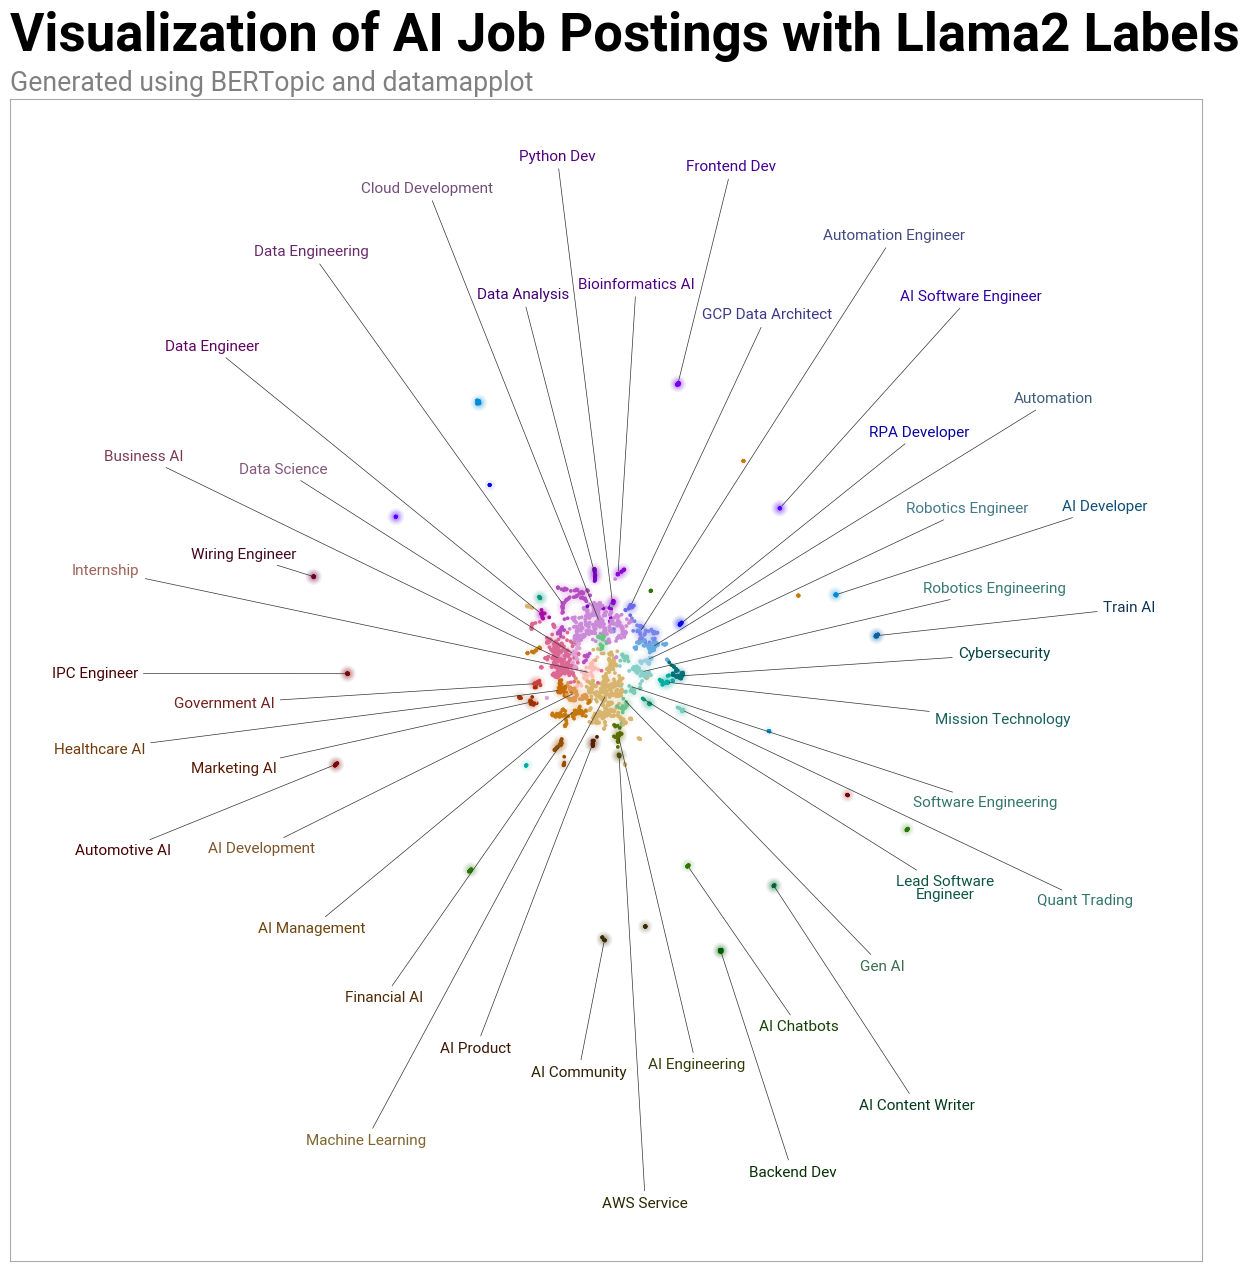

In [ ]:
datamapplot.create_plot(
    data_map_coords=reduced_embeddings,  # Use your 2D embeddings
    labels=flattened_labels,               # Correct argument for labels
    title="Visualization of AI Job Postings with Llama2 Labels",
    sub_title="Generated using BERTopic and datamapplot",
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)